In [876]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from scipy import odr
import matplotlib.colors as mcolors
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm, TABLEAU_COLORS, CSS4_COLORS
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from regions import CirclePixelRegion, PixCoord
from photutils import centroids

#imports
#FOR ASTROQUERRY: If you encounter an error related to "fields" in "SDSS.querry_crossid", try installing the newest development version of astroquerry rather than the default. There is a bug in the older official release version.

In [877]:
#just want to initialize all the data here
def lin_model(p, x): #We need this for ODR later.
    return p[0] * x + p[1]


class Data_Set:
    def ready_frames(self, path):
        night_dir = sorted(glob.glob(path + "/*"))
        opened = [fits.open(file) for file in night_dir]
        self.image_data = [file[1].data for file in opened]
        self.headers = [frame[1].header for frame in opened] #keep all headers
        self.wcs = WCS(self.headers[0]) #wcs should be the same for each set
        self.obs_filter = self.headers[0]['FILTER'][0]
        self.set_length = len(self.image_data)
        self.readout_noise = self.headers[0]['RDNOISE']

    def align_frames(self, frames):
        aligned_frames = [aa.register(frame, frames[0])[0] for frame in frames[0:]]
        #try:
            #aligned_frames = [aa.register(frame, frames[0])[0] for frame in frames[0:]]
            #print("Frames aligned successfully.")
        #except:
            #aligned_frames = self.image_data
            #print("AstroAlign could not align the image data")
        self.aligned_images = aligned_frames

    def combine(self, frames):
        try:
            self.template = np.median(frames, axis = 0)
        except:
            raise UserWarning("Please run self.align_frames() before combining")

    def extract_sources(self, template):
        bkg_phot = sep.Background(template) #background subtract for source extraction.
        self.references = sep.extract(template - bkg_phot.back(),  bkg_phot.globalrms*3, minarea =25, segmentation_map=False)

    def generate_calibration_individual(self, source_list, threshold):
        cal_params = []
        for count in range(len(self.aligned_images)*self.obs_night, len(self.aligned_images)*(1+self.obs_night)):

            inst_mags = [source.instrumental_mags[count] for source in source_list if source.is_reference == True and source.reference_mag < threshold and source.bad_source_flag == False]
            inst_mag_errs = [source.instrumental_mag_errs[count] for source in source_list if source.is_reference == True and source.reference_mag < threshold and source.bad_source_flag == False]

            sky_mags = [source.reference_mag[0] for source in source_list if source.is_reference == True and source.reference_mag < threshold and source.bad_source_flag == False]
            sky_mags_errs = [source.reference_mag_err[0] for source in source_list if source.is_reference == True and source.reference_mag < threshold and source.bad_source_flag == False ]

            linear = odr.Model(lin_model)
            calibration_data = odr.Data(inst_mags, sky_mags, we=inst_mag_errs, wd = sky_mags_errs)
            fit_params = odr.ODR(calibration_data, linear, beta0=[1.0, 23.5]).run() #beta0 is initial guesses
            cal_params.append(fit_params.beta)
        return cal_params

    def __init__(self, path, set_number):
        print(path)
        self.path = path
        self.obs_night = set_number
        self.calibration_parameters = []


In [878]:
class Source:

    def query_source(self):
        search = SDSS.query_crossid(self.ra_dec, fields = ['ra', 'dec', f'psfMag_{Sets[0].obs_filter}', f'psfMagErr_{Sets[0].obs_filter}'], radius = 15 * u.arcsec, region = False)
        if search:
            if search['type'] == "STAR":
                self.is_reference = True
                self.reference_mag = search[f'psfMag_{Sets[0].obs_filter}']
                self.reference_mag_err = search[f'psfMagErr_{Sets[0].obs_filter}']

    def border_check(self, run):
        source_xy = SkyCoord.to_pixel(self.ra_dec, wcs = run.wcs)
        if (run.headers[0]['NAXIS1'] - source_xy[0]) < 0 or source_xy[0] < 0 or (run.headers[0]['NAXIS2'] - source_xy[1]) < 0 or source_xy[1] < 0:
            self.bad_source_flag = True


    def aperture_photometry(self, img, nght):

        coords = SkyCoord.to_pixel(self.ra_dec, wcs = nght.wcs) #gets pixel values of source from RA DEC
        pcoords = PixCoord(coords[0], coords[1]) #another coord object needed for Regions

        radius_i = self.radius
        radius_o_0 = radius_i + 5 #inner annulus radius
        radius_o_1 = radius_o_0 + 5 #outer annulus radius

        source_circle = CirclePixelRegion(pcoords, radius_i).to_mask() #makes region of source shape
        source_aperture = source_circle.cutout(img) #gets data of source


        background_annulus = CircularAnnulus(coords, radius_o_0, radius_o_1)
        background_mean = ApertureStats(img, background_annulus).mean


        source_flux_pix = source_aperture-(source_circle*background_mean) #pixel wise background subtraction
        source_flux_total = np.sum(source_flux_pix) #total flux


        readout_sum_square = np.sum(source_circle*np.float64(nght.readout_noise**2)) #applies square readout noise to source array shape, then adds. Gives sum of square readout noise over back subtracted source.

        delta_n = (readout_sum_square + source_flux_total + (((radius_i**2)/((radius_o_1**2)-(radius_o_0**2)))**2)*(readout_sum_square + aperture_photometry(img, background_annulus)['aperture_sum'][0]))**(1/2)

        if source_flux_total < 0:
            print(self.source_id)
            self.bad_source_flag = True

        else:
            instrumental_mag = -2.5*np.log10(source_flux_total)
            instrumental_mag_error = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total)
            self.instrumental_mags.append(instrumental_mag)
            self.instrumental_mag_errs.append(instrumental_mag_error)

            #return  instrumental_mag, instrumental_mag_error
    def clear_calibration(self):
        self.calibrated_mags = []

    def clear_mags(self):
        self.instrumental_mags = []
        self.instrumental_mag_errs = []

    def calibrate_source(self, calibration):
        for c, mag in enumerate(self.instrumental_mags):
            self.calibrated_mags.append(np.float64(mag*calibration[c][0] + calibration[c][1]))

    def get_info(self):
        return(self.ra_dec, f"Source Radius: {self.radius}", f"Source Id: {self.source_id}", f"Is Reference Star: {self.is_reference}" , f"Is Bad Source: {self.bad_source_flag}" )

    def __init__(self, source, Id, W):
        self.ra_dec = pixel_to_skycoord(source['x'], source['y'], W).transform_to('icrs') #gives wcs transformation for pixel coordinates
        self.radius = (source['xmax'] - source['xmin'])/2
        self.source_id = Id
        self.is_reference = None #these fields will populate after running their respective functions
        self.bad_source_flag = False
        self.instrumental_mags = []
        self.instrumental_mag_errs = []
        self.calibrated_mags = []


In [879]:

files = sorted(glob.glob("/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/*")) #filepath for multi, this is a directory containing directories.
Sets = [Data_Set(directory, run_number) for run_number, directory in enumerate(files)] #initialize the sets
total_frames = 0
for i, night in enumerate(Sets):
    night.ready_frames(night.path) #opens files, pulls image and header data for use
    night.align_frames(night.image_data) #tries to align frames
    night.combine(night.aligned_images) #makes median template
    night.extract_sources(night.template) #extracts sources
    total_frames += len(night.image_data) #running total on number of frames




/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_02r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_03r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_06r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_07r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_08r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_09r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_10r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_11r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_12r
/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/sn2023ixf_13r


In [880]:
#source querying
wcs_matrix = Sets[0].wcs
sources = [Source(source, count, wcs_matrix) for count, source in enumerate(Sets[0].references)] #initializes each source
for s in sources:
    s.query_source()

In [881]:
for source in sources:
    source.clear_mags() #if using jupyter notebook, allows for re-running kernel

#aperture photometry:
for night in Sets:
    for image in night.aligned_images:
        for source in sources:
            source.border_check(night)
            if source.bad_source_flag == False:
                try:
                    source.aperture_photometry(image, night)
                except:
                    print(f"Negative Flux Source Encountered at RA_DEC:{source.ra_dec}")



In [882]:
#calibration:
for source in sources:
    source.clear_calibration() #if using jupyter notebook, allows for re running kernel.

mag_thresh = 18 #make a click option
calibration_parameters = []
night_array =[]

for night in Sets:
    calibration_parameters.append(night.generate_calibration_individual(sources, mag_thresh))
    for image in night.aligned_images:
        night_array.append(night.obs_night)
calibration_parameters = np.concatenate(calibration_parameters)

for source in sources:
    source.calibrate_source(calibration_parameters)

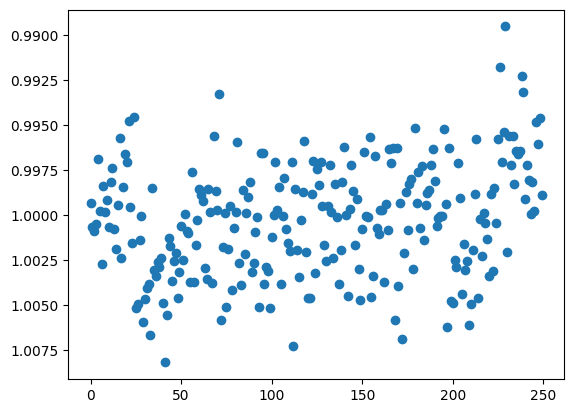

In [883]:
l = np.arange(0, len(calibration_parameters))
curves = [source.calibrated_mags for source in sources if source.bad_source_flag == False]
med_curve = np.median(curves, axis = 0)/np.median(curves)
plt.scatter(l, med_curve)
plt.gca().invert_yaxis()
plt.show()


(<SkyCoord (ICRS): (ra, dec) in deg
    (210.78272351, 54.45971846)>, 'Source Radius: 5.0', 'Source Id: 0', 'Is Reference Star: None', 'Is Bad Source: False')


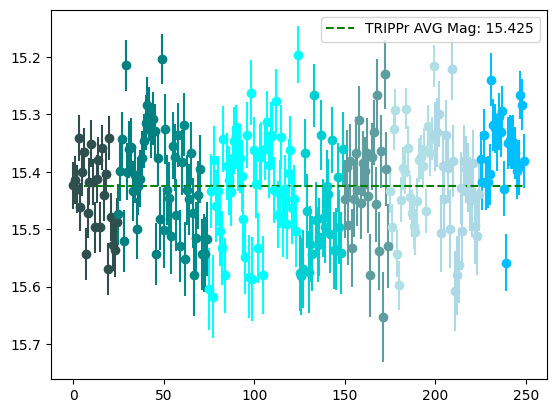

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.77550571, 54.14508597)>, 'Source Radius: 3.0', 'Source Id: 1', 'Is Reference Star: None', 'Is Bad Source: False')


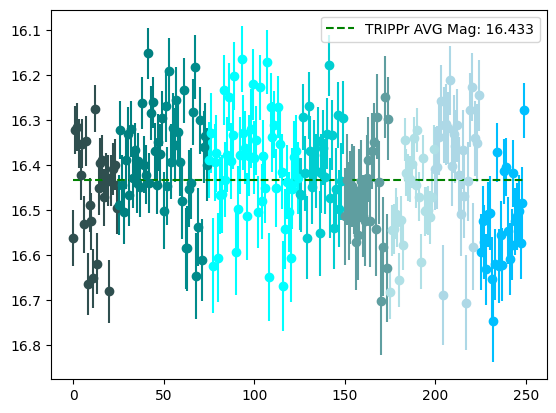

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.79248564, 54.39747745)>, 'Source Radius: 5.0', 'Source Id: 2', 'Is Reference Star: None', 'Is Bad Source: False')


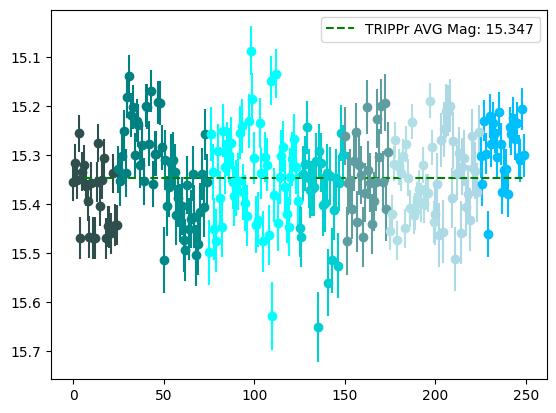

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.80186801, 54.29859178)>, 'Source Radius: 3.0', 'Source Id: 3', 'Is Reference Star: None', 'Is Bad Source: False')


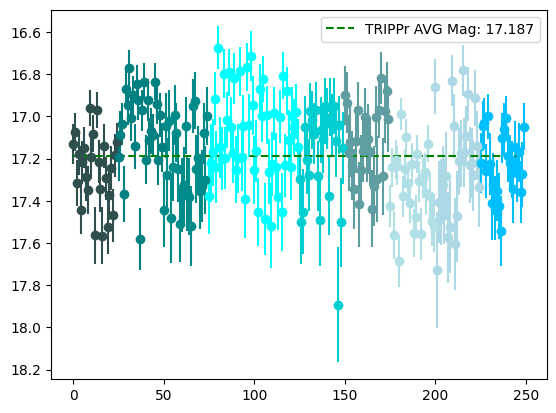

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.79447654, 54.0838712)>, 'Source Radius: 4.5', 'Source Id: 4', 'Is Reference Star: None', 'Is Bad Source: False')


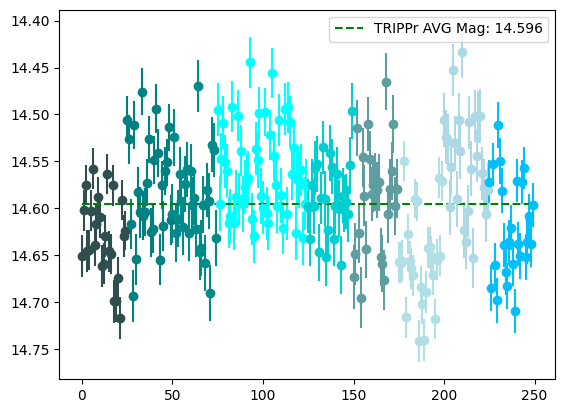

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.80206959, 54.34873014)>, 'Source Radius: 27.5', 'Source Id: 5', 'Is Reference Star: None', 'Is Bad Source: False')


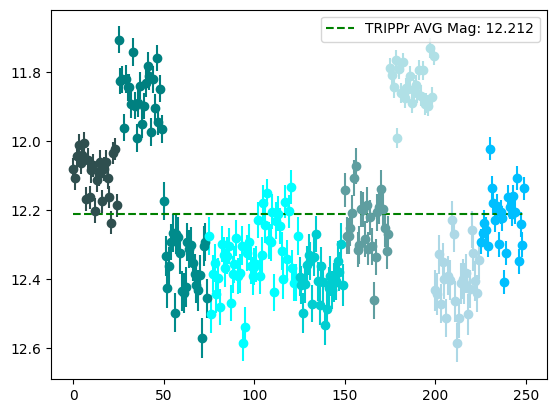

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.80676757, 54.26196473)>, 'Source Radius: 6.5', 'Source Id: 6', 'Is Reference Star: None', 'Is Bad Source: False')


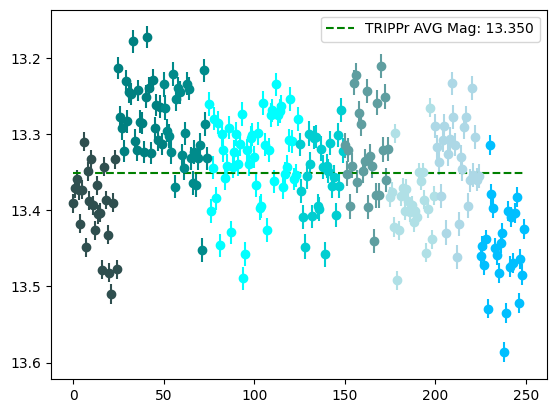

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.81073532, 54.37035913)>, 'Source Radius: 9.0', 'Source Id: 7', 'Is Reference Star: None', 'Is Bad Source: False')


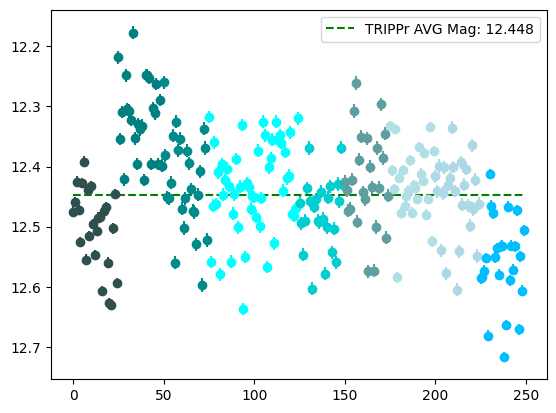

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.8152421, 54.45781723)>, 'Source Radius: 6.5', 'Source Id: 8', 'Is Reference Star: None', 'Is Bad Source: False')


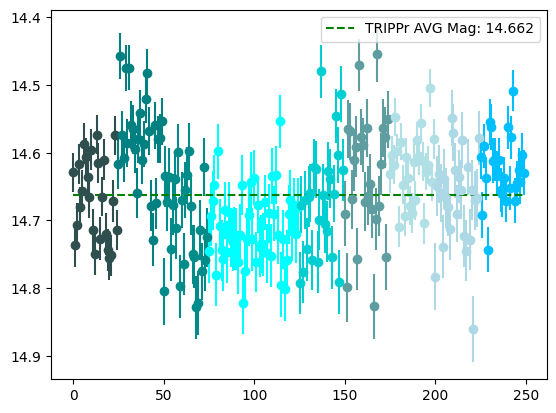

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.80834476, 54.11467639)>, 'Source Radius: 2.5', 'Source Id: 9', 'Is Reference Star: None', 'Is Bad Source: False')


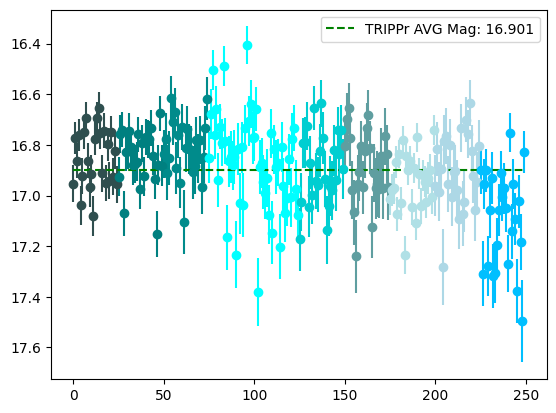

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.81572421, 54.26237173)>, 'Source Radius: 3.0', 'Source Id: 10', 'Is Reference Star: None', 'Is Bad Source: False')


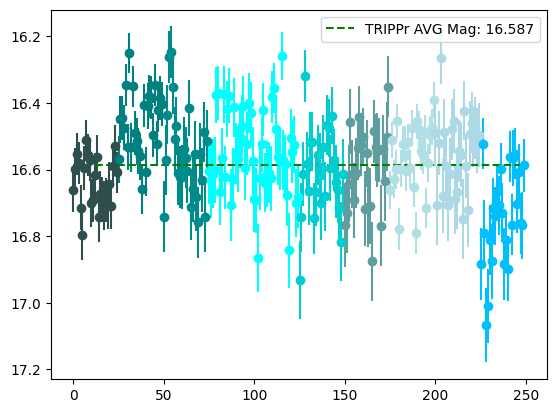

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.82637993, 54.34790299)>, 'Source Radius: 4.0', 'Source Id: 11', 'Is Reference Star: None', 'Is Bad Source: False')


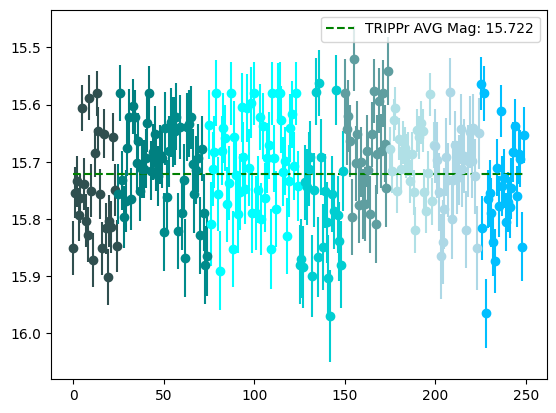

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.84294319, 54.26012276)>, 'Source Radius: 5.5', 'Source Id: 12', 'Is Reference Star: None', 'Is Bad Source: False')


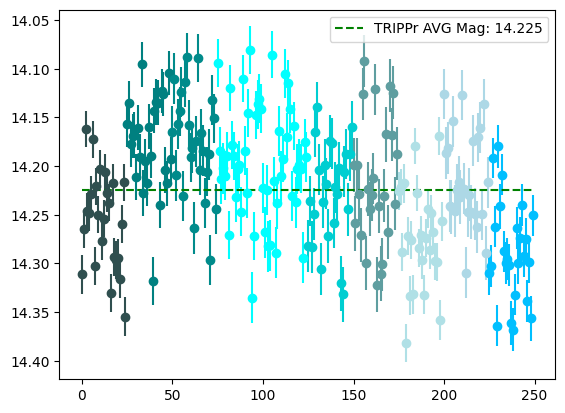

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.83908433, 54.0373817)>, 'Source Radius: 7.0', 'Source Id: 13', 'Is Reference Star: True', 'Is Bad Source: False')
     psfMag_r     
------------------
0.3272490558812624


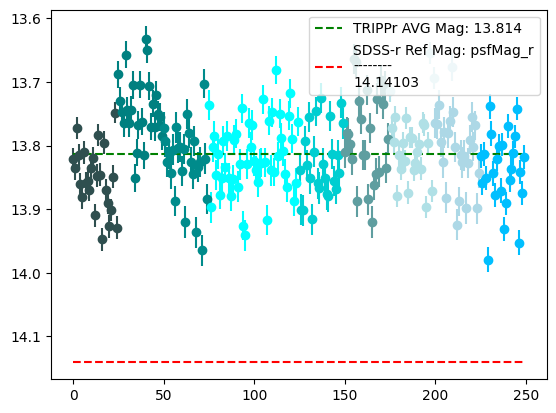

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.8491348, 54.27057194)>, 'Source Radius: 2.5', 'Source Id: 14', 'Is Reference Star: None', 'Is Bad Source: False')


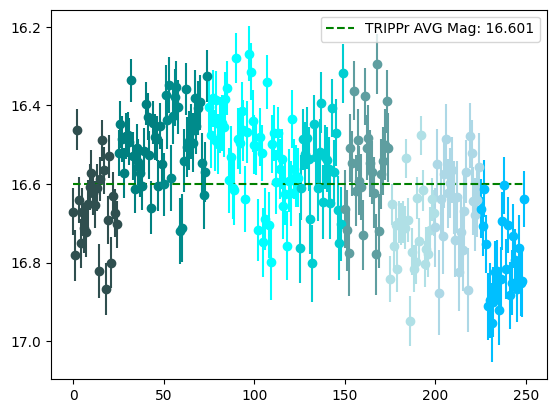

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.84889875, 54.24229868)>, 'Source Radius: 4.0', 'Source Id: 15', 'Is Reference Star: None', 'Is Bad Source: False')


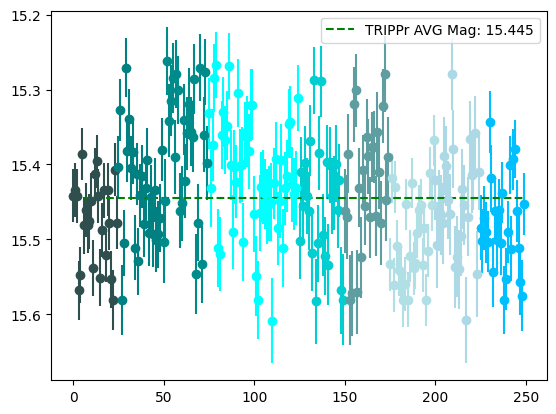

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.85672758, 54.37867585)>, 'Source Radius: 3.5', 'Source Id: 16', 'Is Reference Star: None', 'Is Bad Source: False')


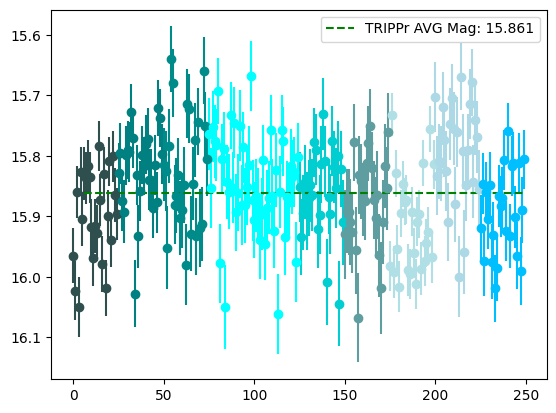

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.85366314, 54.23249378)>, 'Source Radius: 3.5', 'Source Id: 17', 'Is Reference Star: None', 'Is Bad Source: False')


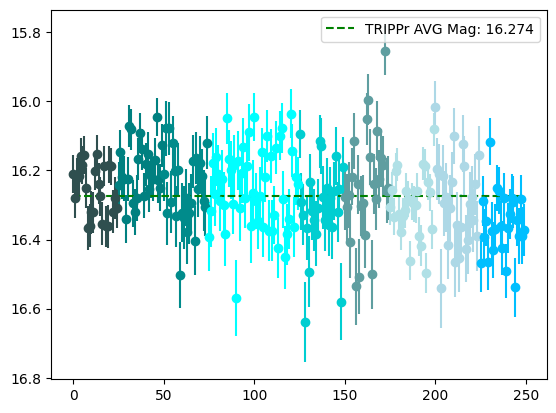

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.85030384, 54.12207102)>, 'Source Radius: 2.5', 'Source Id: 18', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r      
--------------------
-0.42172744750952873


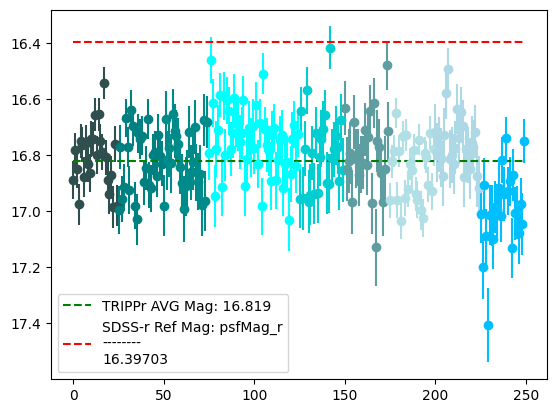

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.85063554, 54.04551099)>, 'Source Radius: 3.5', 'Source Id: 19', 'Is Reference Star: True', 'Is Bad Source: False')
     psfMag_r     
------------------
0.7730627199589293


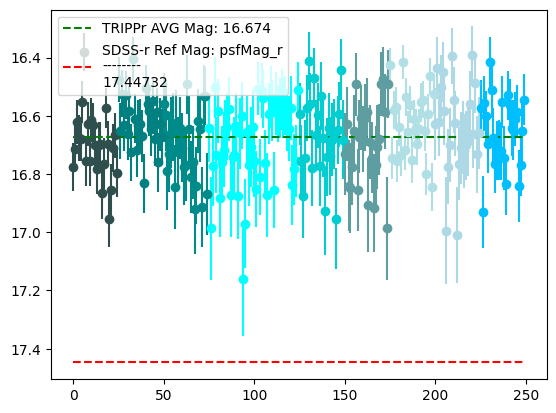

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.86518663, 54.31283836)>, 'Source Radius: 4.0', 'Source Id: 20', 'Is Reference Star: None', 'Is Bad Source: False')


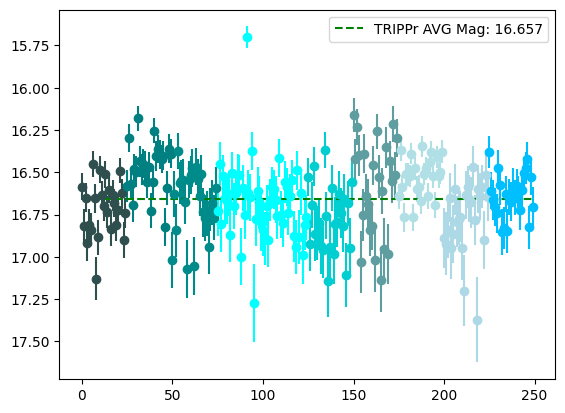

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.86800042, 54.35876675)>, 'Source Radius: 3.0', 'Source Id: 21', 'Is Reference Star: None', 'Is Bad Source: False')


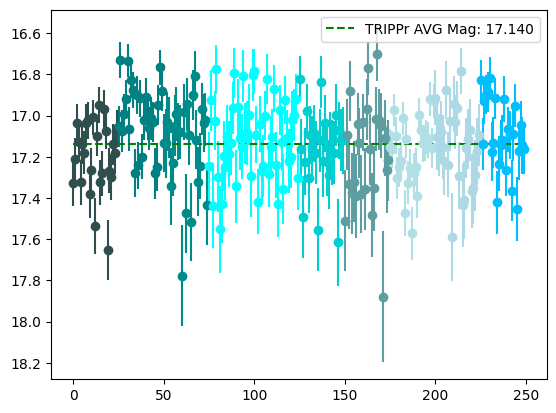

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.86386421, 54.06701257)>, 'Source Radius: 6.0', 'Source Id: 22', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r     
-------------------
0.11978120774218581


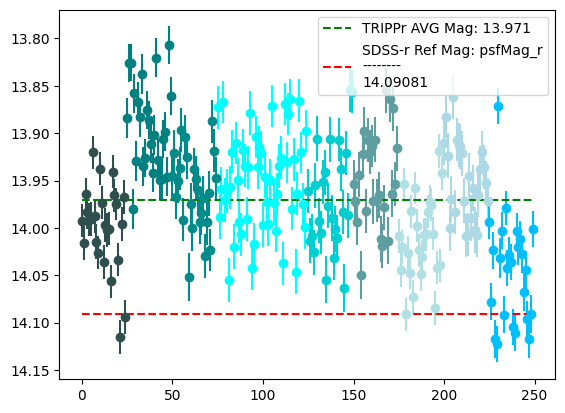

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.8615306, 54.00013879)>, 'Source Radius: 6.5', 'Source Id: 23', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r     
-------------------
0.32915389097342995


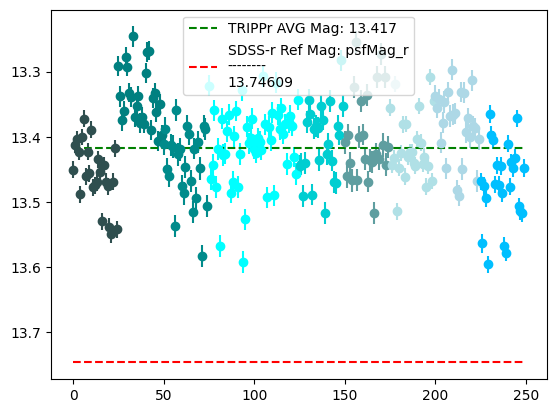

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.87048358, 54.19250825)>, 'Source Radius: 3.5', 'Source Id: 24', 'Is Reference Star: None', 'Is Bad Source: False')


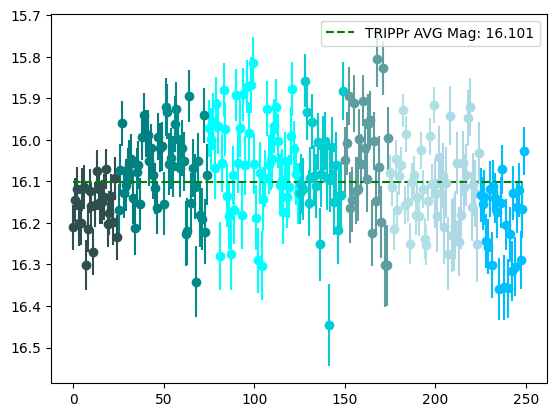

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.8805303, 54.35398963)>, 'Source Radius: 4.0', 'Source Id: 25', 'Is Reference Star: None', 'Is Bad Source: False')


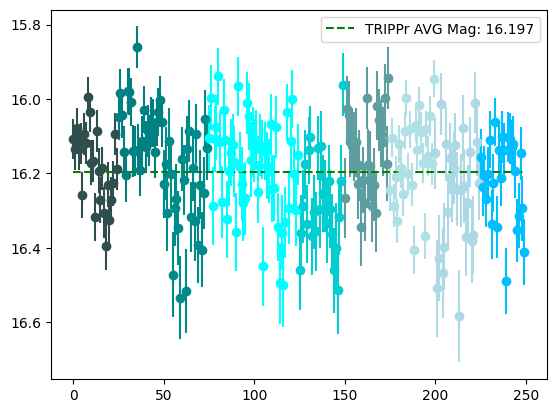

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.87569614, 54.06163606)>, 'Source Radius: 4.0', 'Source Id: 26', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r      
--------------------
-0.06104732548155489


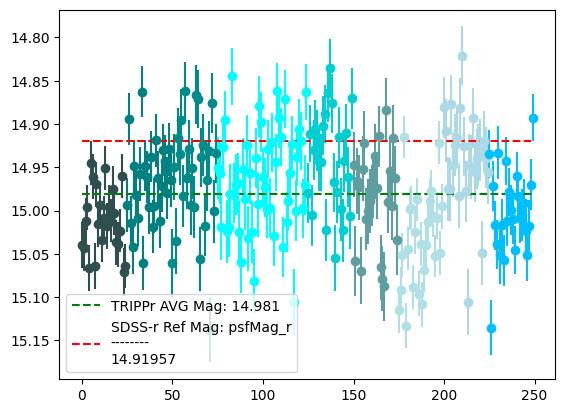

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.88734587, 54.38781215)>, 'Source Radius: 5.5', 'Source Id: 27', 'Is Reference Star: None', 'Is Bad Source: False')


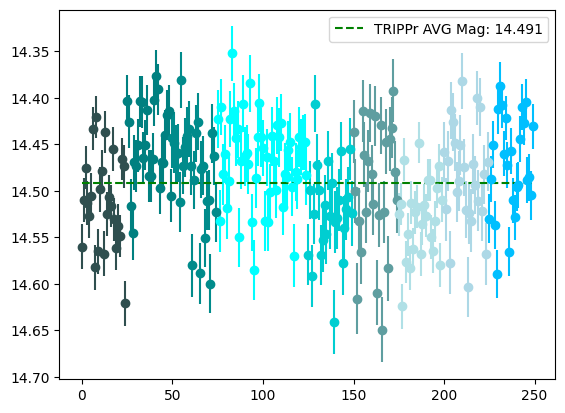

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.88665759, 54.33614578)>, 'Source Radius: 2.5', 'Source Id: 28', 'Is Reference Star: None', 'Is Bad Source: False')


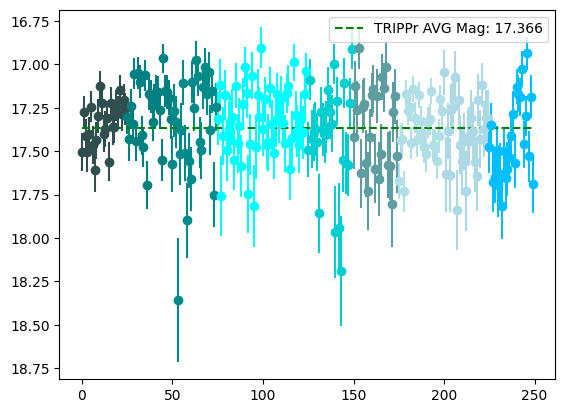

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.88500977, 54.28890995)>, 'Source Radius: 3.5', 'Source Id: 29', 'Is Reference Star: None', 'Is Bad Source: False')


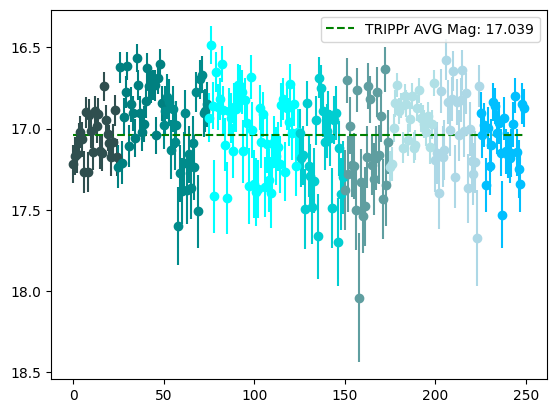

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.88362985, 54.1138174)>, 'Source Radius: 4.0', 'Source Id: 30', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r      
--------------------
-0.10109286512441429


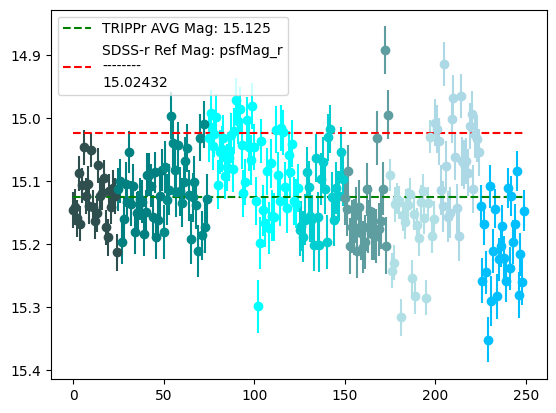

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.89603392, 54.43759338)>, 'Source Radius: 4.5', 'Source Id: 31', 'Is Reference Star: None', 'Is Bad Source: False')


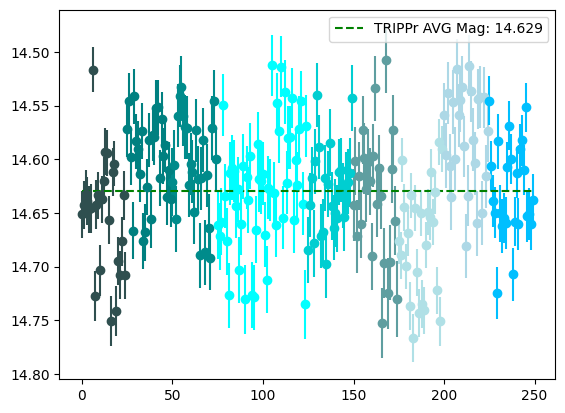

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.89840483, 54.3416589)>, 'Source Radius: 4.5', 'Source Id: 32', 'Is Reference Star: None', 'Is Bad Source: False')


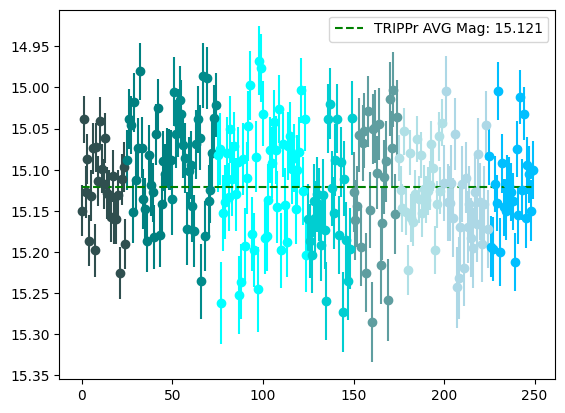

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.90052695, 54.34964825)>, 'Source Radius: 3.0', 'Source Id: 33', 'Is Reference Star: None', 'Is Bad Source: False')


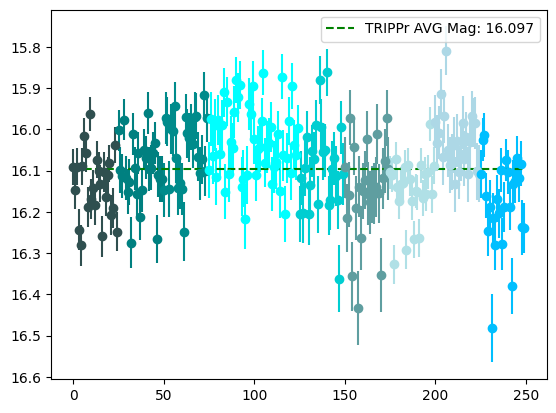

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.91055426, 54.31169678)>, 'Source Radius: 14.0', 'Source Id: 34', 'Is Reference Star: None', 'Is Bad Source: False')


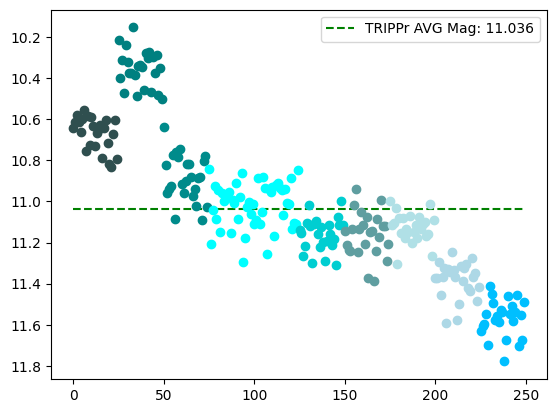

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.91689781, 54.39173506)>, 'Source Radius: 4.0', 'Source Id: 35', 'Is Reference Star: None', 'Is Bad Source: False')


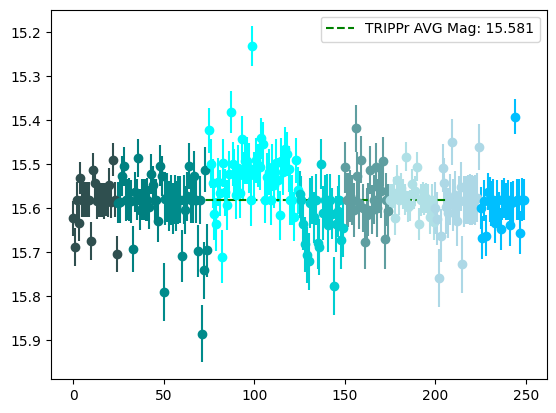

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.91605555, 54.31568738)>, 'Source Radius: 3.5', 'Source Id: 36', 'Is Reference Star: None', 'Is Bad Source: False')


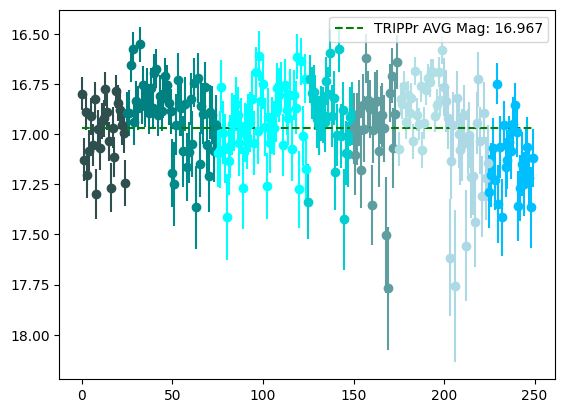

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.92241703, 54.31797144)>, 'Source Radius: 10.0', 'Source Id: 37', 'Is Reference Star: None', 'Is Bad Source: False')


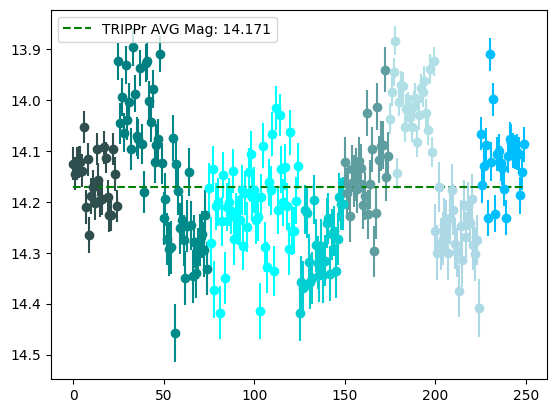

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.9417537, 54.44672344)>, 'Source Radius: 4.0', 'Source Id: 38', 'Is Reference Star: None', 'Is Bad Source: False')


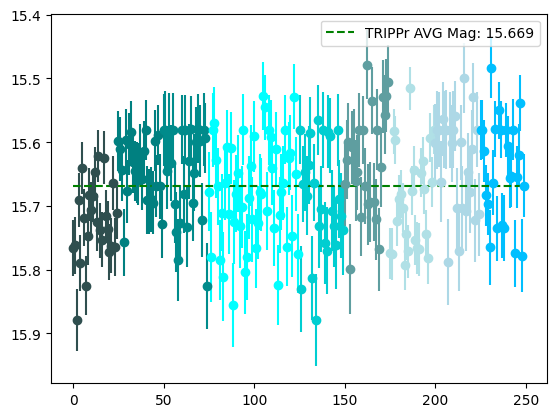

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.93805894, 54.27106037)>, 'Source Radius: 6.0', 'Source Id: 39', 'Is Reference Star: None', 'Is Bad Source: False')


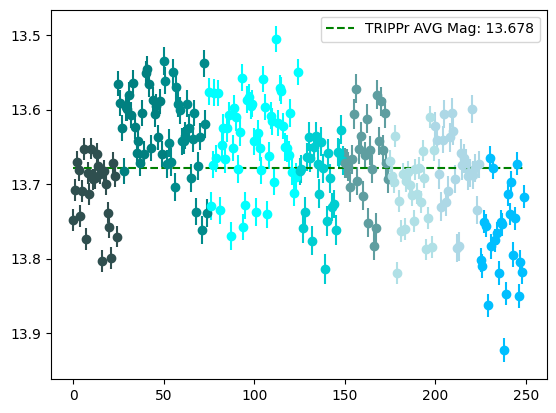

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.94550841, 54.29515842)>, 'Source Radius: 3.5', 'Source Id: 40', 'Is Reference Star: None', 'Is Bad Source: False')


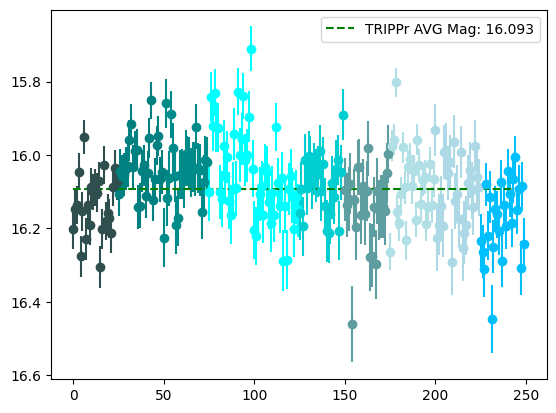

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.95617089, 54.46091011)>, 'Source Radius: 3.0', 'Source Id: 41', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r      
--------------------
-0.20902350345814114


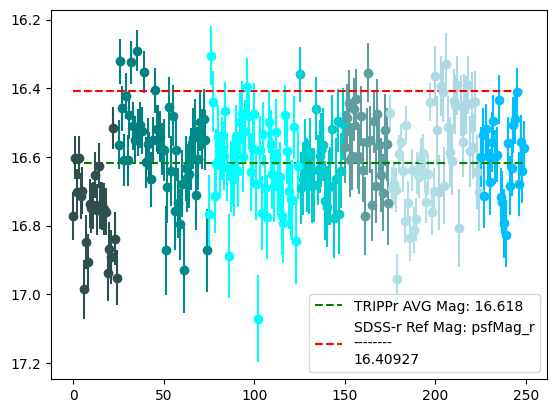

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.95549419, 54.41993155)>, 'Source Radius: 2.5', 'Source Id: 42', 'Is Reference Star: None', 'Is Bad Source: False')


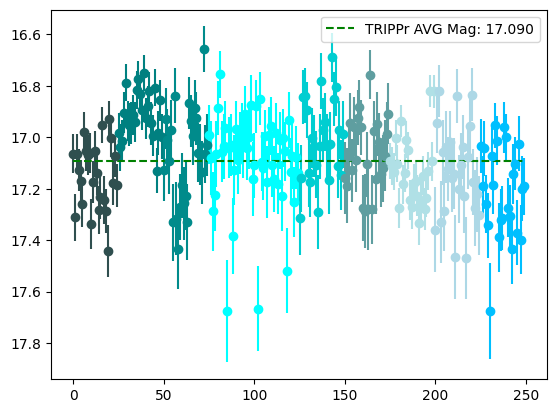

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.95776278, 54.15153029)>, 'Source Radius: 11.5', 'Source Id: 43', 'Is Reference Star: True', 'Is Bad Source: False')
     psfMag_r     
------------------
0.5077241505116508


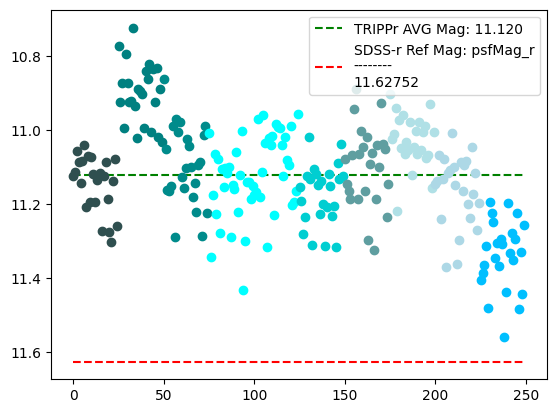

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.97193498, 54.36827617)>, 'Source Radius: 3.5', 'Source Id: 44', 'Is Reference Star: None', 'Is Bad Source: False')


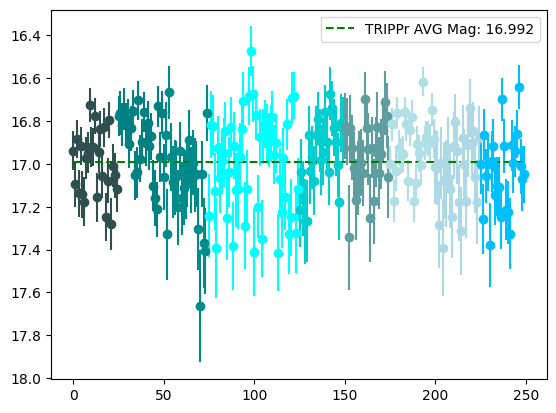

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.97523909, 54.36934526)>, 'Source Radius: 5.5', 'Source Id: 45', 'Is Reference Star: None', 'Is Bad Source: False')


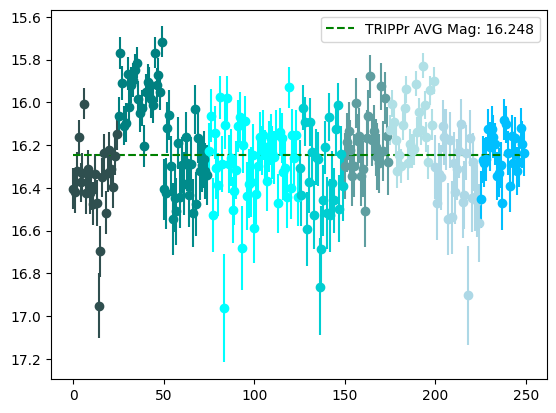

(<SkyCoord (ICRS): (ra, dec) in deg
    (210.98336712, 54.34931789)>, 'Source Radius: 3.0', 'Source Id: 46', 'Is Reference Star: None', 'Is Bad Source: False')


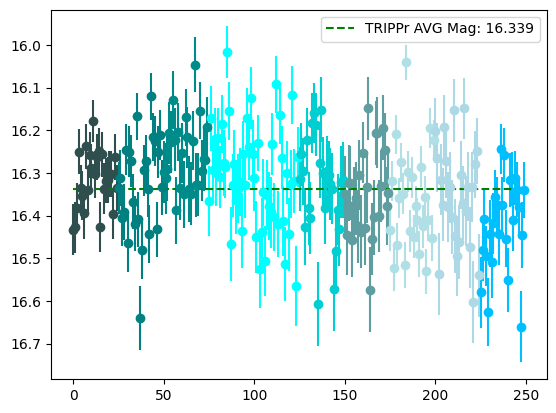

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.01134848, 54.30502921)>, 'Source Radius: 7.0', 'Source Id: 47', 'Is Reference Star: None', 'Is Bad Source: False')


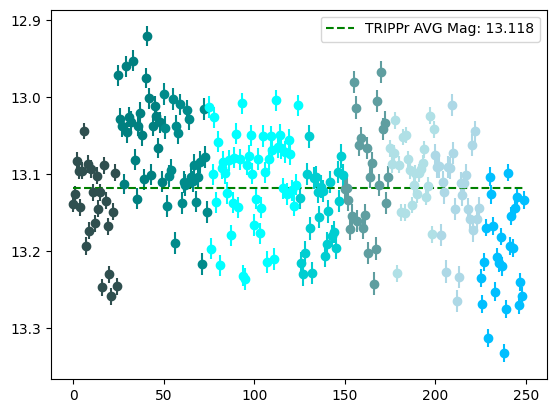

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.01156344, 54.16910002)>, 'Source Radius: 4.0', 'Source Id: 48', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r      
--------------------
-0.12890161568783576


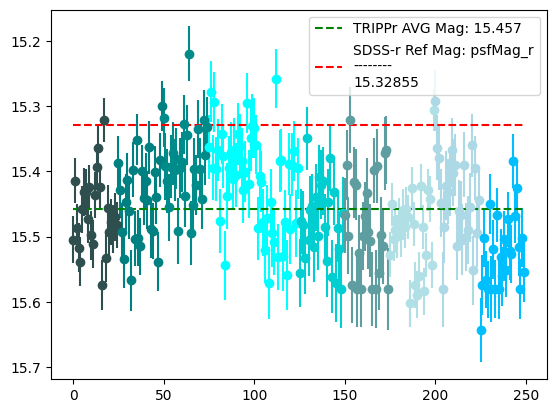

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.00453763, 53.98887093)>, 'Source Radius: 5.5', 'Source Id: 49', 'Is Reference Star: True', 'Is Bad Source: False')
     psfMag_r     
------------------
1.0181136577591339


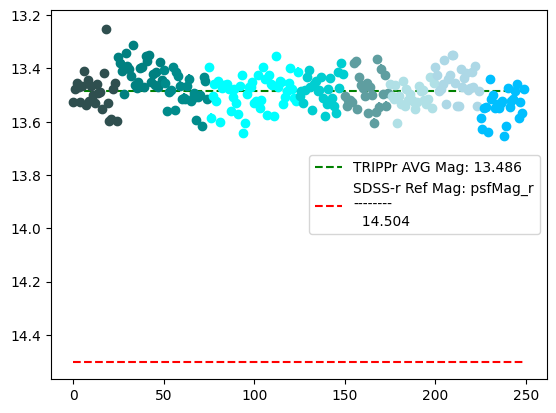

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.01841136, 54.22552572)>, 'Source Radius: 6.5', 'Source Id: 50', 'Is Reference Star: None', 'Is Bad Source: False')


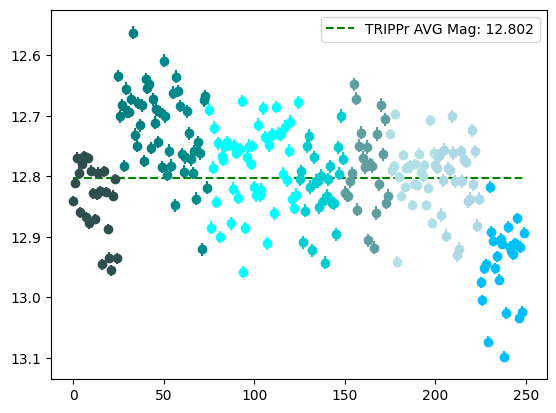

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.03006488, 54.35204566)>, 'Source Radius: 4.0', 'Source Id: 51', 'Is Reference Star: None', 'Is Bad Source: False')


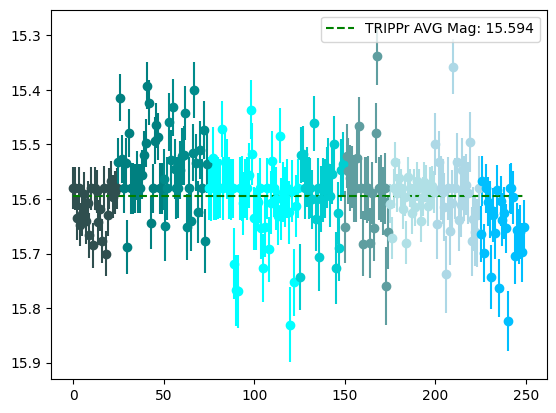

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.04682416, 54.42158107)>, 'Source Radius: 4.5', 'Source Id: 52', 'Is Reference Star: None', 'Is Bad Source: False')


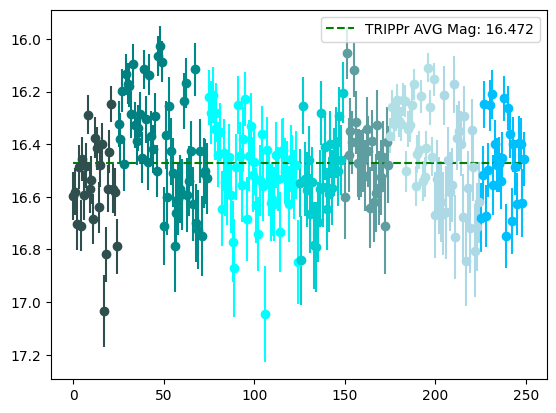

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.03188549, 54.00407838)>, 'Source Radius: 4.5', 'Source Id: 53', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r      
--------------------
0.005390018157424237


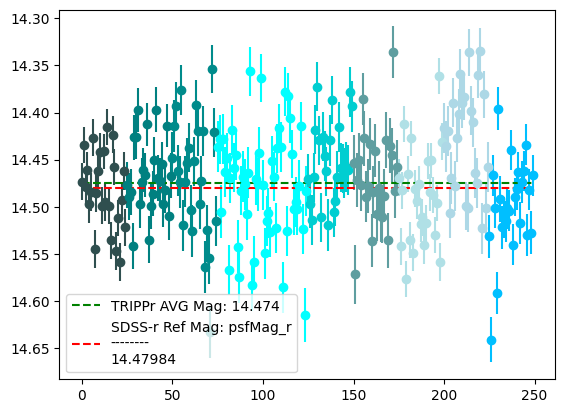

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.05144253, 54.23152052)>, 'Source Radius: 3.0', 'Source Id: 54', 'Is Reference Star: None', 'Is Bad Source: False')


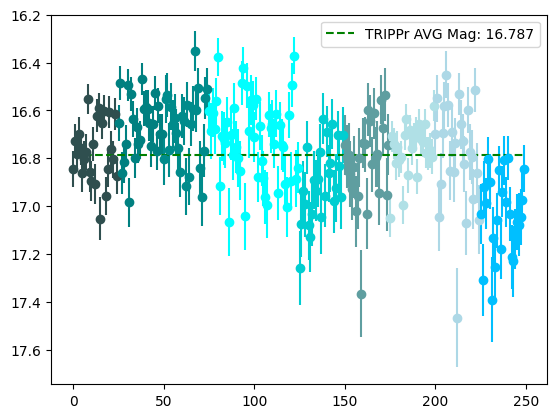

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.04809302, 53.9938326)>, 'Source Radius: 3.0', 'Source Id: 55', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r     
-------------------
-0.2825186520821621


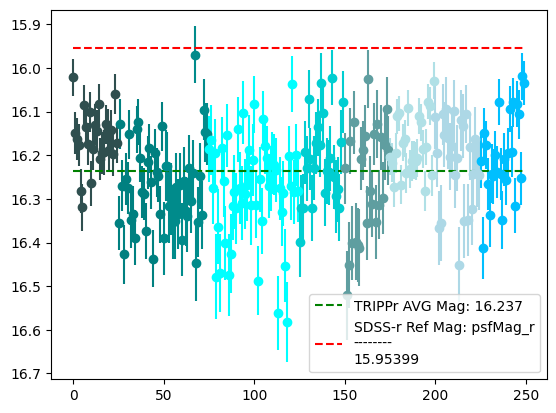

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.0674882, 54.42881879)>, 'Source Radius: 5.5', 'Source Id: 56', 'Is Reference Star: True', 'Is Bad Source: False')
     psfMag_r    
-----------------
9.509139761953804


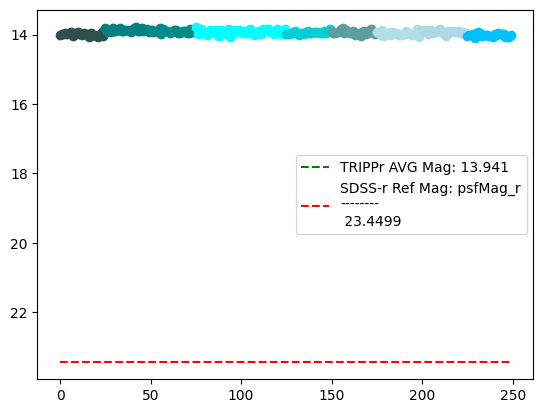

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.06828153, 54.39069706)>, 'Source Radius: 4.0', 'Source Id: 57', 'Is Reference Star: None', 'Is Bad Source: False')


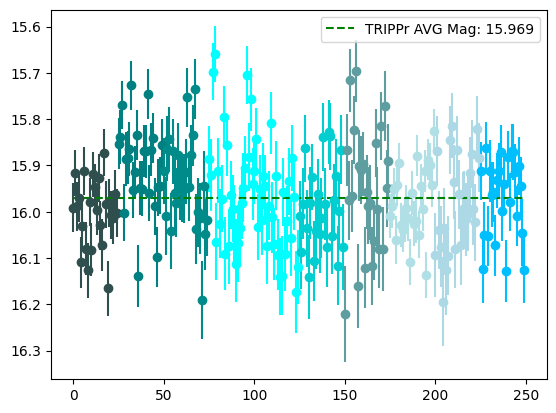

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.06442548, 54.00816578)>, 'Source Radius: 7.0', 'Source Id: 58', 'Is Reference Star: True', 'Is Bad Source: False')
     psfMag_r     
------------------
0.2767882672604536


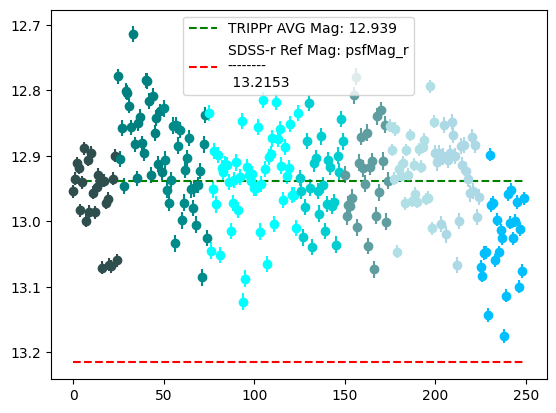

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.08497635, 54.39021174)>, 'Source Radius: 6.5', 'Source Id: 59', 'Is Reference Star: None', 'Is Bad Source: False')


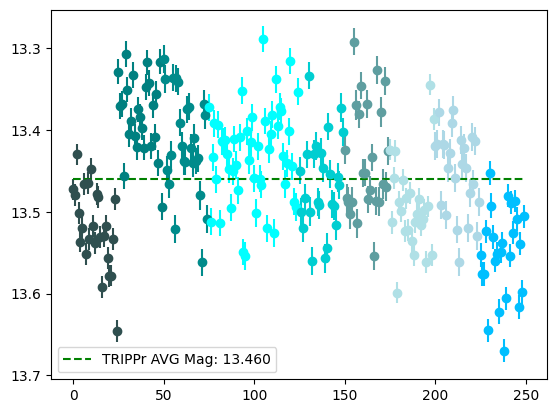

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.09030766, 54.32292807)>, 'Source Radius: 10.5', 'Source Id: 60', 'Is Reference Star: None', 'Is Bad Source: False')


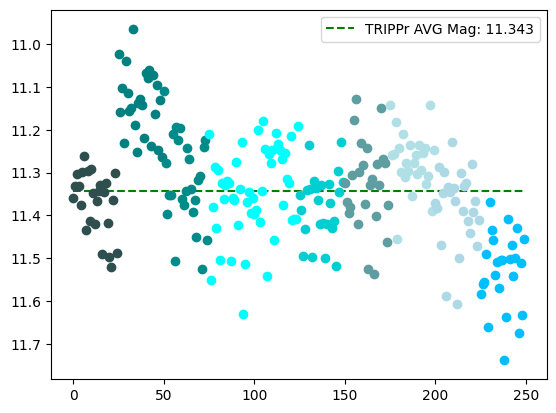

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.12036051, 54.39700063)>, 'Source Radius: 7.5', 'Source Id: 61', 'Is Reference Star: None', 'Is Bad Source: False')


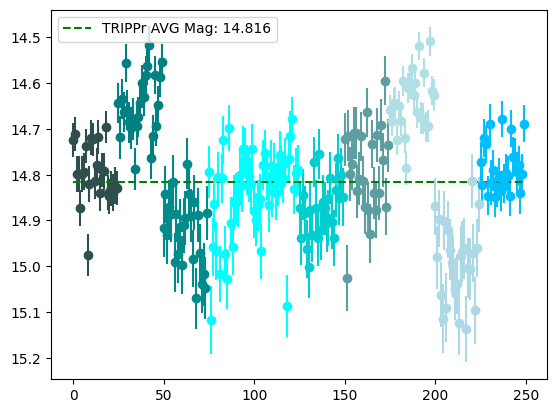

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.12238072, 54.3964228)>, 'Source Radius: 9.5', 'Source Id: 62', 'Is Reference Star: None', 'Is Bad Source: False')


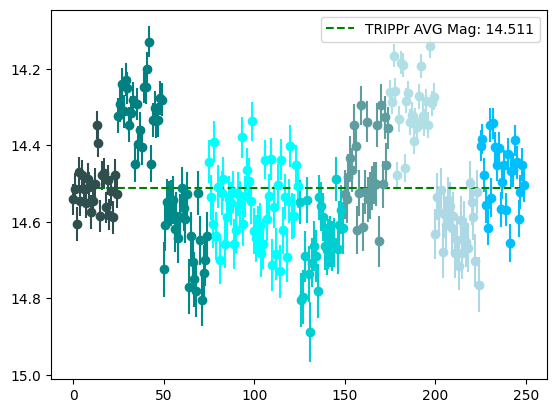

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.12184327, 54.39801681)>, 'Source Radius: 5.5', 'Source Id: 63', 'Is Reference Star: None', 'Is Bad Source: False')


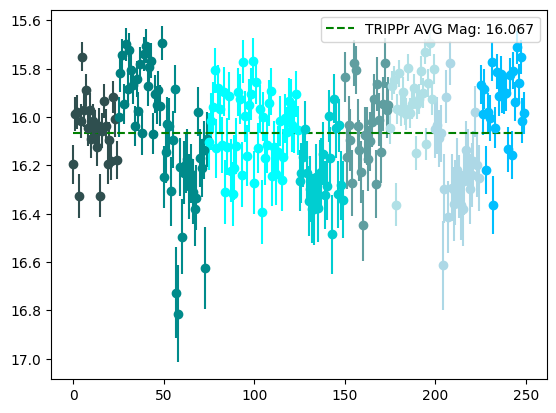

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.12521481, 54.25972344)>, 'Source Radius: 3.0', 'Source Id: 64', 'Is Reference Star: None', 'Is Bad Source: False')


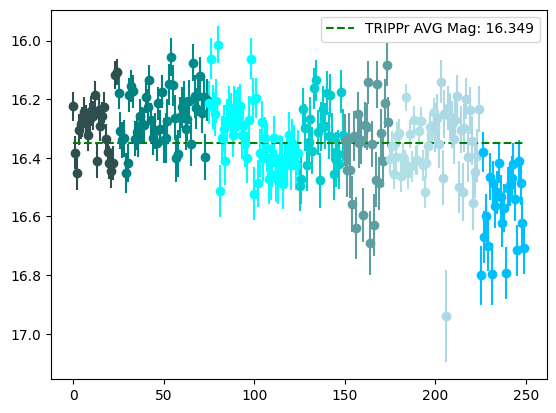

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.12054456, 54.08428834)>, 'Source Radius: 5.0', 'Source Id: 65', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r     
-------------------
0.08833224943003337


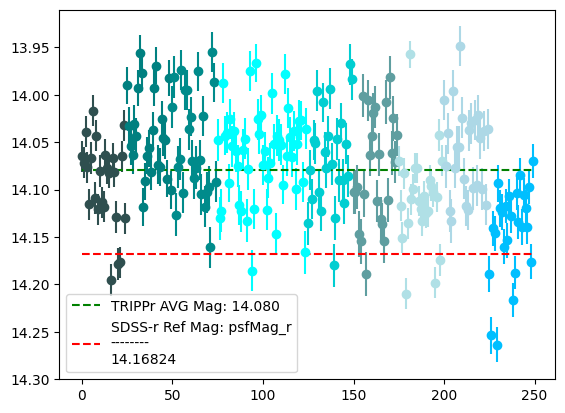

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.17529361, 54.35187118)>, 'Source Radius: 9.5', 'Source Id: 66', 'Is Reference Star: None', 'Is Bad Source: False')


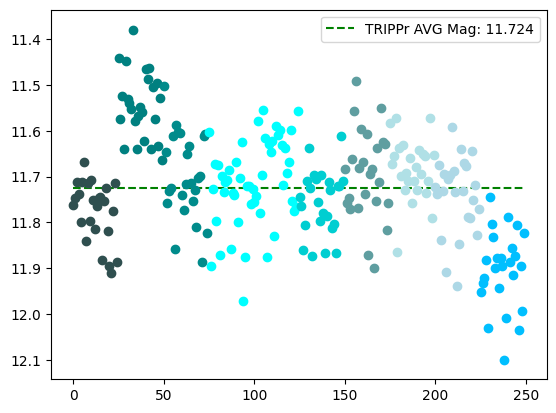

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.21211591, 54.19464639)>, 'Source Radius: 3.5', 'Source Id: 67', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r      
--------------------
-0.18505661048816968


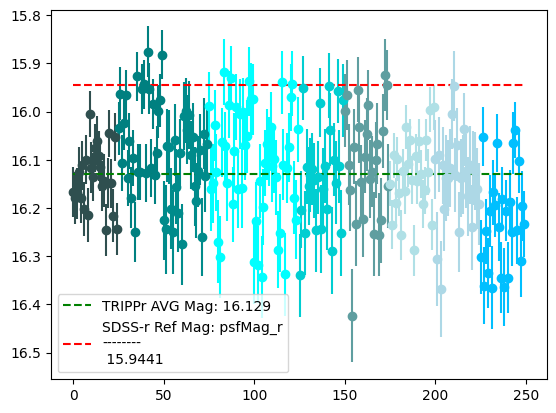

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.231828, 54.40298931)>, 'Source Radius: 5.0', 'Source Id: 68', 'Is Reference Star: None', 'Is Bad Source: False')


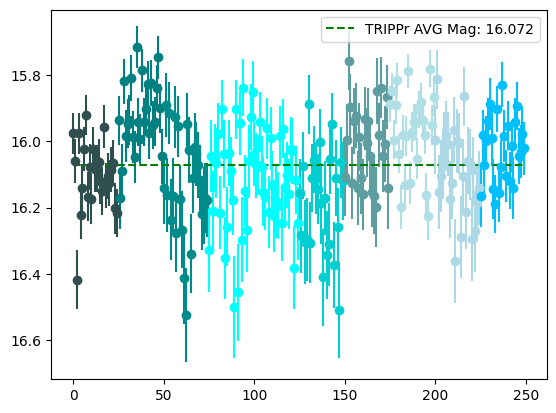

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.23332181, 54.22956903)>, 'Source Radius: 2.5', 'Source Id: 69', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r     
-------------------
-0.4079189178914895


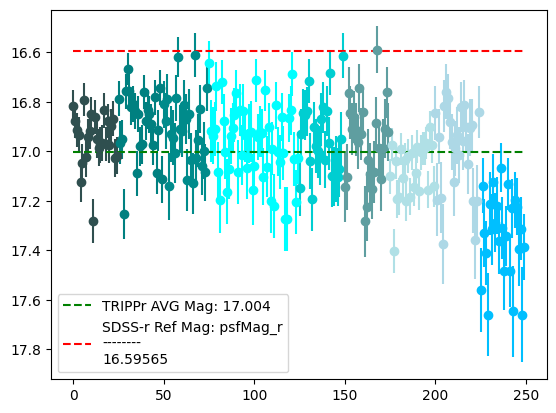

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.25972667, 54.33924396)>, 'Source Radius: 7.0', 'Source Id: 70', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r     
-------------------
0.24503644198379781


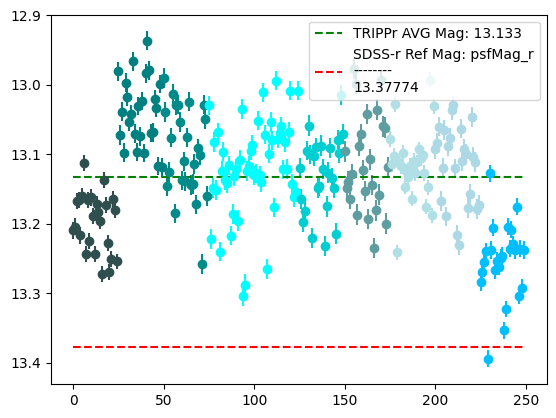

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.27877934, 54.05855765)>, 'Source Radius: 21.0', 'Source Id: 71', 'Is Reference Star: True', 'Is Bad Source: False')
     psfMag_r     
------------------
0.8385736551073748


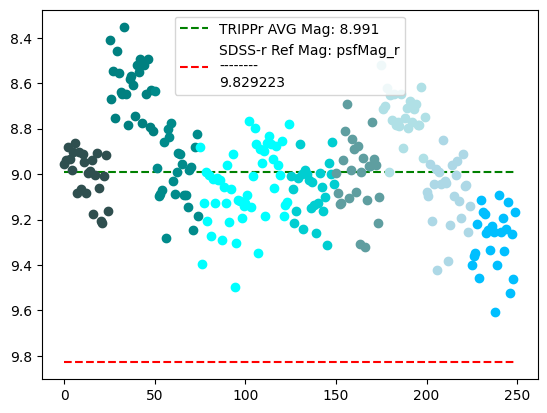

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.30345384, 54.41397668)>, 'Source Radius: 3.0', 'Source Id: 72', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r     
-------------------
-0.2553452502813762


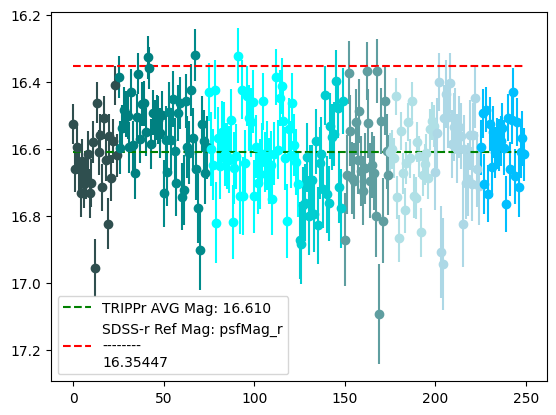

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.29844756, 54.26495767)>, 'Source Radius: 3.0', 'Source Id: 73', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r      
--------------------
-0.24160453513892932


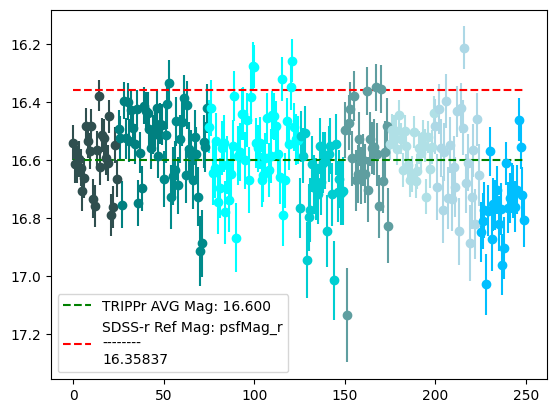

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.30476211, 54.37648842)>, 'Source Radius: 3.5', 'Source Id: 74', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r      
--------------------
-0.18549179635093438


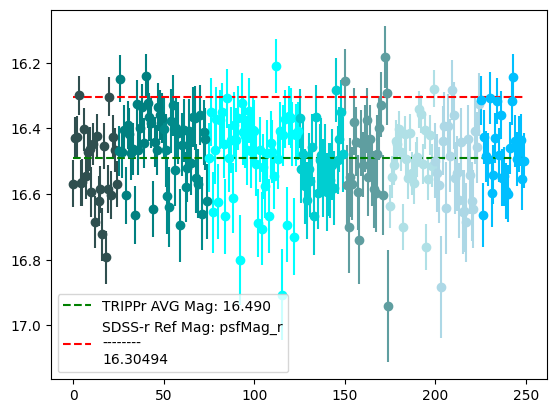

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.30066365, 54.21154036)>, 'Source Radius: 5.0', 'Source Id: 75', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r      
--------------------
0.045983211214393194


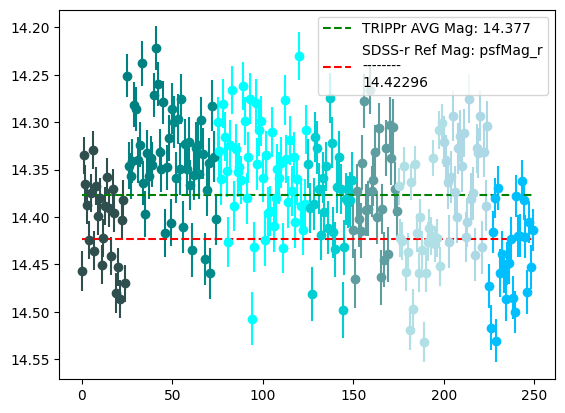

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.29289799, 53.99842441)>, 'Source Radius: 3.5', 'Source Id: 76', 'Is Reference Star: True', 'Is Bad Source: False')
      psfMag_r      
--------------------
-0.19094077346632687


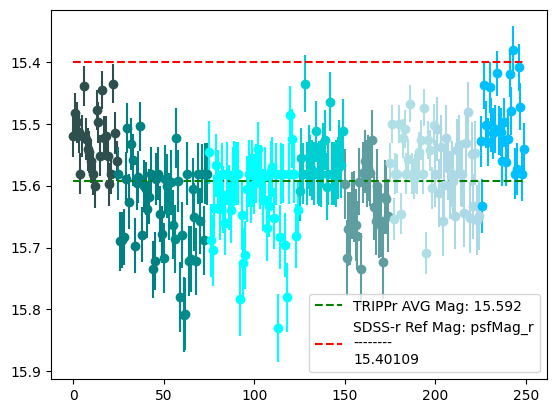

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.30979078, 54.07608885)>, 'Source Radius: 3.0', 'Source Id: 77', 'Is Reference Star: True', 'Is Bad Source: True')
      psfMag_r     
-------------------
-0.1765074072654862


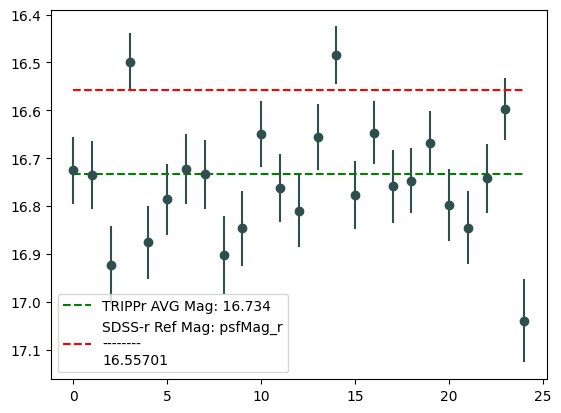

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.32647274, 54.42447666)>, 'Source Radius: 3.0', 'Source Id: 78', 'Is Reference Star: True', 'Is Bad Source: True')
     psfMag_r     
------------------
-0.168044154964047


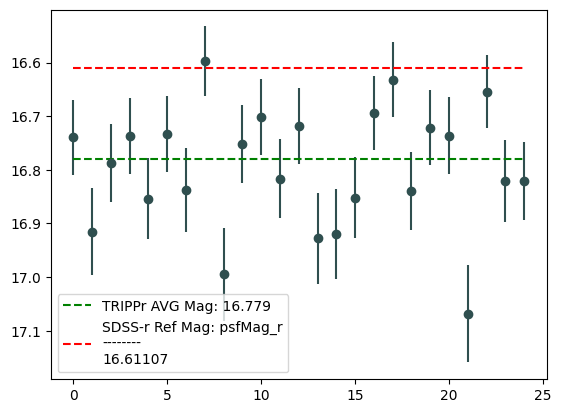

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.31921793, 54.17948362)>, 'Source Radius: 4.0', 'Source Id: 79', 'Is Reference Star: True', 'Is Bad Source: True')
      psfMag_r     
-------------------
-0.0870415612354396


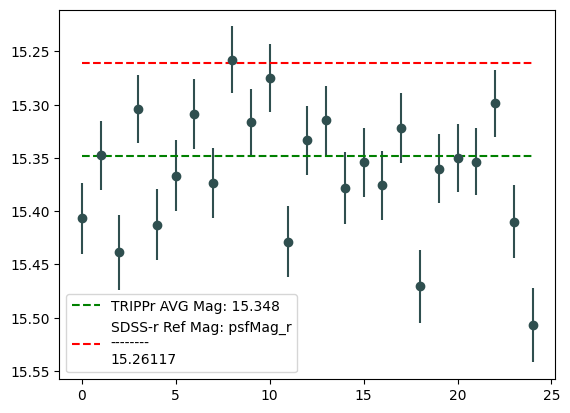

(<SkyCoord (ICRS): (ra, dec) in deg
    (211.31467094, 54.01658955)>, 'Source Radius: 5.0', 'Source Id: 80', 'Is Reference Star: True', 'Is Bad Source: True')
      psfMag_r     
-------------------
0.11995857279474187


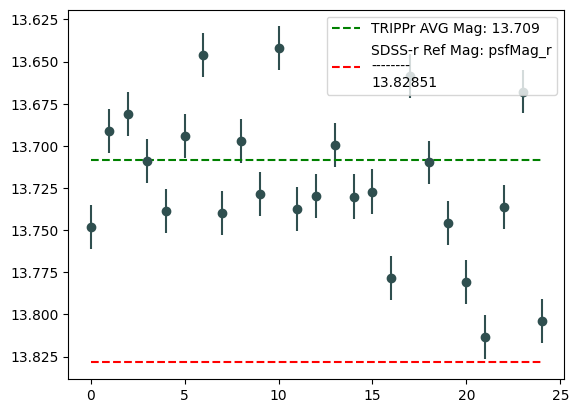

In [893]:
color_arr = np.array(sorted(CSS4_COLORS, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c)))))
#print(color_arr[93::5][np.array(night_array)])
for source in sources:
    print(source.get_info())
    r = np.arange(0, len(source.calibrated_mags))

    for i, value in enumerate(source.calibrated_mags):
        plt.errorbar(i, value/med_curve[i], yerr=source.instrumental_mag_errs[i], linestyle = 'none', marker = 'o', c = color_arr[93::1][np.array(night_array)][i] )

    avg_mag =  np.mean(source.calibrated_mags)
    avg_mag_str = "%.3f" % avg_mag
    plt.plot(r, np.ones(len(r))*avg_mag, linestyle = '--', color = "g", label = f"TRIPP{Sets[0].obs_filter} AVG Mag: {avg_mag_str}")
    if source.is_reference:
        plt.plot(r, np.ones(len(r))*source.reference_mag, linestyle = '--', color = "r", label = f"SDSS-{Sets[0].obs_filter} Ref Mag: {source.reference_mag}")
        print(source.reference_mag-avg_mag)

    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()


In [895]:
differences = []
for source in sources:
    if source.is_reference == True:
        average_magnitude = np.median(source.calibrated_mags)
        differences.append(source.reference_mag - average_magnitude)

avg_diff = np.median(differences)
std_diff = np.std(differences)

print(f"<Class Version> Average Difference:{avg_diff}, Standard Deviation in Differences:{std_diff}")


<Class Version> Average Difference:-0.060372795446269834, Standard Deviation in Differences:1.760074709499815


In [885]:

""" #code for calibration plots
count = 0
for night in Sets:
    for image in night.aligned_images:
        for source in sources:
            if source.is_reference == True and source.reference_mag < mag_thresh and source.bad_source_flag == False:
                plt.scatter(source.instrumental_mags[i], source.reference_mag, color = 'r')
        x = np.arange(-15, 0)
        plt.plot(x, x*calibration_parameters[count][0] + calibration_parameters[count][1], color = 'b')
        plt.title(f"m: {calibration_parameters[count][0]}, b: {calibration_parameters[count][1]}, night: {night.obs_night}, count: {count}")
        plt.show()
        count += 1
"""

""" #code for viewing each template with sources and their apertures
for i, night in enumerate(Sets):
    for source in sources:
        x, y = SkyCoord.to_pixel(source.ra_dec, wcs= night.wcs)
        circle0 = plt.Circle((x, y), source.radius, color = 'r', fill = False)
        circle1 = plt.Circle((x, y), source.radius + 5, color = 'b', fill = False)
        circle2 = plt.Circle((x,y), source.radius +5, color = 'g',fill = False)
        ax = plt.gca()
        ax.add_patch(circle0)
        ax.add_patch(circle1)
        ax.add_patch(circle2)
    plt.imshow(night.template, cmap= 'gray', norm= LogNorm(vmin = 1, vmax = 200))
    plt.show()
"""



" #code for viewing each template with sources and their apertures\nfor i, night in enumerate(Sets):\n    for source in sources:\n        x, y = SkyCoord.to_pixel(source.ra_dec, wcs= night.wcs)\n        circle0 = plt.Circle((x, y), source.radius, color = 'r', fill = False)\n        circle1 = plt.Circle((x, y), source.radius + 5, color = 'b', fill = False)\n        circle2 = plt.Circle((x,y), source.radius +5, color = 'g',fill = False)\n        ax = plt.gca()\n        ax.add_patch(circle0)\n        ax.add_patch(circle1)\n        ax.add_patch(circle2)\n    plt.imshow(night.template, cmap= 'gray', norm= LogNorm(vmin = 1, vmax = 200))\n    plt.show()\n"